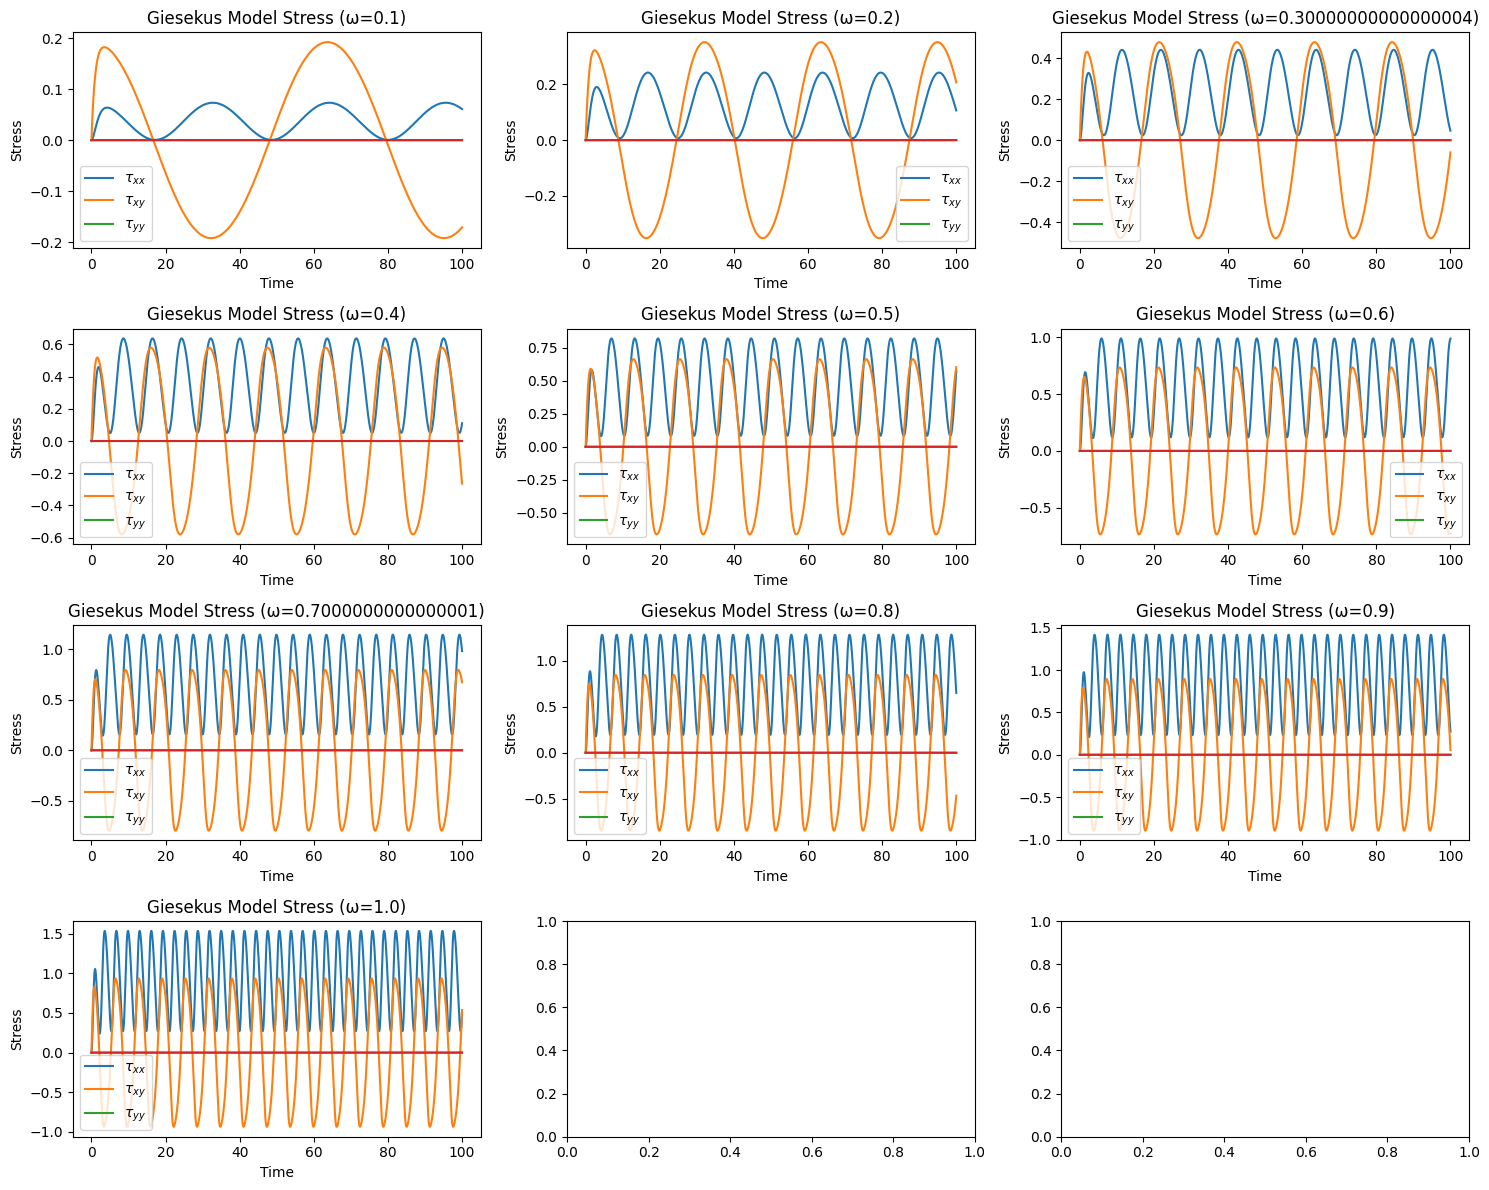

-0.862 -0.8086 1.999 1.0 -0.999 0.0 0.0


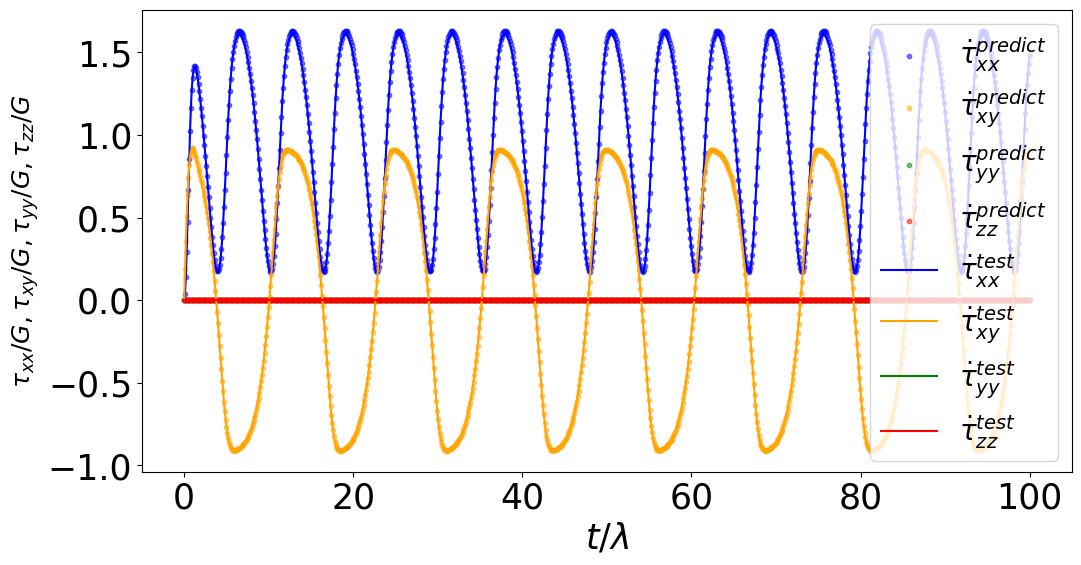

In [1]:
#PTTモデルの構成方程式を用いて訓練データを生成し、SINDyを用いて構成方程式を推定する
#alpha=1e-5
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import matplotlib.pyplot as plt
import copy

def PTT_stress(t, y, shear_rate):
    G = 1.0
    ε = 0.5

    gamma_dot = shear_rate(t)

    dtau_xx_dt = 2 * G * gamma_dot * y[1] - np.exp(ε * (y[0] + y[2] + y[3]) / G) * y[0]
    dtau_xy_dt = gamma_dot * y[2] - np.exp(ε * (y[0] + y[2] + y[3]) / G) * y[1] + G * gamma_dot
    dtau_yy_dt = - np.exp(ε * (y[0] + y[2] + y[3]) / G) * y[2]
    dtau_zz_dt = - np.exp(ε * (y[0] + y[2] + y[3]) / G) * y[3]

    return [dtau_xx_dt, dtau_xy_dt, dtau_yy_dt, dtau_zz_dt]

def shear_rate(t, omega):
    return 2 * omega * np.cos(omega * t)

def generate_data(num_omega):
	tau0_xx, tau0_xy, tau0_yy, tay0_zz = 0.0, 0.0, 0.0, 0.0
	initial_conditions = [tau0_xx, tau0_xy, tau0_yy, tay0_zz]

	t_span = (0, 100)
	t_train = np.linspace(*t_span, 10000)	
	x_train = np.zeros((len(t_train) * num_omega, 4))
	u_train = np.zeros((len(t_train) * num_omega, 1))
    
	num_rows = (num_omega + 2) // 3  # 列ごとに3つのプロット
	fig, axs = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))
	for i in range(num_omega):
		omega = 0.1 + i * 0.1
		shear_rate_func = lambda t: shear_rate(t, omega)
		x_train_i = solve_ivp(
		    PTT_stress,
		    t_span,
		    initial_conditions,
		    args=(shear_rate_func,),
		    method='RK45',
		    t_eval=t_train
		).y.T
        #plot
		row_idx = i // 3  # 行のインデックス
		col_idx = i % 3   # 列のインデックス
		axs[row_idx, col_idx].plot(t_train, x_train_i)
		axs[row_idx, col_idx].set_xlabel('Time')
		axs[row_idx, col_idx].set_ylabel('Stress')
		axs[row_idx, col_idx].set_title(f'Giesekus Model Stress (ω={omega})')
		axs[row_idx, col_idx].legend(['$τ_{xx}$', '$τ_{xy}$', '$τ_{yy}$'])
		x_train[i * len(t_train):(i + 1) * len(t_train), :] = x_train_i
		u_train[i * len(t_train):(i + 1) * len(t_train), :] = shear_rate(t_train, omega=omega).reshape(-1, 1)
	fig.tight_layout()
	plt.show()
	x_train_columns = ['τxx', 'τxy', 'τyy', 'τzz']
	x_train = pd.DataFrame(x_train, columns = x_train_columns)
	u_train_column = ['κxy']
	#u_train = shear_rate(t_train).reshape(-1, 1)
	u_train = pd.DataFrame(u_train, columns = u_train_column)
	return t_train, x_train, u_train

#候補関数にcustomとしてtraceを追加
def prepare_data_for_sindy(data, control, ε):
    poly = PolynomialFeatures(degree=2)
    data.columns = ['τxx', 'τxy', 'τyy', 'τzz']
    control.columns = ['κxy']
    combined_data = pd.concat([data, control], axis=1)
    custom = np.exp(ε * (combined_data['τxx'] + combined_data['τyy'] + combined_data['τzz']) / 1.0)
    combined_data['exp(ε * trace /G)'] = custom
    RHS = poly.fit_transform(combined_data)
    feature_names = poly.get_feature_names_out(['τxx', 'τxy', 'τyy', 'τzz', 'κxy', 'exp(ε * trace /G)'])
    RHS_df = pd.DataFrame(RHS, columns=feature_names)
    return RHS_df

def calculate_finite_difference(data, t, num_omega):
    ddate_list = []
    num_partitions = num_omega
    data_len = len(data) // num_partitions
    for i in range(num_omega):
        start_idx = i * data_len
        end_idx = (i + 1) * data_len
        data_subset = data.iloc[start_idx:end_idx, :]
        ddate_subset = ps.FiniteDifference(order=3)._differentiate(data_subset.values, t)
        ddate_list.append(ddate_subset)
    ddate = np.concatenate(ddate_list, axis=0)
    columns_prime = ['τxx_prime', 'τxy_prime', 'τyy_prime', 'τzz_prime']
    ddate_df = pd.DataFrame(ddate, columns=columns_prime)
    return ddate_df

def adaptive_lasso_regression(RHS, LHS, alpha):
    n_lasso_iterations = 1000
    tol = 0.0001
    kaijo = 4
    abs1 = lambda w: (np.abs(w)**kaijo + 1e-30)

    weights = np.ones(RHS.shape[1])

    for _ in range(n_lasso_iterations):
        prev_weights = np.copy(weights)
        RHS_w = RHS / weights[np.newaxis, :]
        clf = Lasso(alpha=alpha, fit_intercept=False, max_iter=n_lasso_iterations, tol=tol)
        clf.fit(RHS_w, LHS)
        coef_ = clf.coef_ / weights
        weights = 1 / abs1(coef_)
        if np.mean((weights - prev_weights)**2) < tol:
            break

    return coef_

def get_coefficients_df(coefficients, variable_name, alpha):
    df = pd.DataFrame(coefficients, index=RHS.columns, columns=[f"{variable_name}_{alpha}"])
    return df

ε = 0.5
t_train, x_train, u_train = generate_data(num_omega=10)
RHS = prepare_data_for_sindy(x_train, u_train, ε=ε)
RHS0 = copy.deepcopy(RHS)
RHS1 = copy.deepcopy(RHS)
RHS2 = copy.deepcopy(RHS)
RHS3 = copy.deepcopy(RHS)

LHS = calculate_finite_difference(x_train, t_train, num_omega=10)
#ここまでが同じ
alpha = 1e-5
ε = 0.5
coef_τxx = adaptive_lasso_regression(RHS0, LHS['τxx_prime'], alpha)
coef_τxy = adaptive_lasso_regression(RHS1, LHS['τxy_prime'], alpha)
coef_τyy = adaptive_lasso_regression(RHS2, LHS['τyy_prime'], alpha)
coef_τzz = adaptive_lasso_regression(RHS3, LHS['τzz_prime'], alpha)

τxx = coef_τxx.T
τxy = coef_τxy.T
τyy = coef_τyy.T
τzz = coef_τzz.T

τxx = τxx.astype(np.float16)
τxy = τxy.astype(np.float16)
τyy = τyy.astype(np.float16)
τzz = τzz.astype(np.float16)

print(τxx[1], τxx[7], τxx[16], τxy[5], τxy[17], τyy[0], τzz[0])
#τxyのgamma_dot * y[0]は係数0.0になっているので、除外。
def PTT_stress_predict(t, y, shear_rate):
    # 剪断速度関数
    gamma_dot = shear_rate(t)

    dtau_xx_dt = τxx[1] * y[0] + τxx[7] * (y[0] ** 2) + τxx[16] * gamma_dot * y[1] 
    dtau_xy_dt = τxy[5] * gamma_dot + τxy[17] * np.exp(ε * (y[0] + y[2] + y[3])) * y[1]
    dtau_yy_dt = τyy[0] * y[2]
    dtau_zz_dt = τzz[0] * y[3]
    return [dtau_xx_dt, dtau_xy_dt, dtau_yy_dt, dtau_zz_dt]

# 初期条件
tau0_xx = 0.0
tau0_xy = 0.0
tau0_yy = 0.0
tau0_zz = 0.0
initial_conditions = [tau0_xx, tau0_xy, tau0_yy, tau0_zz]

def shear_rate_test(t, omega=0.5):
    return 4 * omega * np.cos(omega * t)

# 時間の範囲
t_span = (0, 100)
t_test = np.linspace(0, 100, 1000)

x_predict = solve_ivp(
    PTT_stress_predict,
    t_span,
    initial_conditions,
    args=(shear_rate_test,),
    method='RK45',
    t_eval=t_test
).y.T

x_test = solve_ivp(
    PTT_stress,
	t_span,
	initial_conditions,
	args=(shear_rate_test,),
	method='RK45',
	t_eval=t_test
).y.T

# 結果のプロット
plt.figure(figsize=(12, 6))

# Plot x_predict as points
plt.scatter(t_test, x_predict[:, 0], label=r'$\dot{\tau}_{xx}^{predict}$', color='blue', marker='o', s=10, alpha=0.5)
plt.scatter(t_test, x_predict[:, 1], label=r'$\dot{\tau}_{xy}^{predict}$', color='orange', marker='o', s=10, alpha=0.5)
plt.scatter(t_test, x_predict[:, 2], label=r'$\dot{\tau}_{yy}^{predict}$', color='green', marker='o', s=10, alpha=0.5)
plt.scatter(t_test, x_predict[:, 3], label=r'$\dot{\tau}_{zz}^{predict}$', color='red', marker='o', s=10, alpha=0.5)

# Plot x_test as lines
plt.plot(t_test, x_test[:, 0], label=r'$\dot{\tau}_{xx}^{test}$', color='blue')
plt.plot(t_test, x_test[:, 1], label=r'$\dot{\tau}_{xy}^{test}$', color='orange')
plt.plot(t_test, x_test[:, 2], label=r'$\dot{\tau}_{yy}^{test}$', color='green')
plt.plot(t_test, x_test[:, 3], label=r'$\dot{\tau}_{zz}^{test}$', color='red')

plt.xlabel(r'$\mathit{t}/\lambda$', fontsize=25)
plt.ylabel('$τ_{xx}/G,τ_{xy}/G,τ_{yy}/G,τ_{zz}/G$', fontsize=18, labelpad=5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)  # Display legend if labels are provided

plt.show()